# Lab07: Model Integration with Modules

## Objectives
1. Review principles and methods for building dynamic models in biology.
2. Examine examples of process-based crop models that integrate underlying processes as sub-models through modular structure. 
3. Experiment with applying integrative models to address research questions and real world problems.

## SimpleCrop Example from DSSAT Cropping Systems Model

In this section, we review a simple crop model to demonstrate how different aspects of crop growth and development we have learned so far could be synthesized into a single model.

[The reference model](https://dssat.net/development/model-development/) was originally developed for illustrating how a crop model could be developed following a modular approach used by [DSSAT Cropping Systems Model](https://dssat.net) which is one of the most widely used and developed collection of crop models. The sample model was coded in Fortran 90 and published as a part of [research report](http://dssat.net/wp-content/uploads/2014/03/modular.pdf) in 1999.

![Schematic of modular structure](https://dssat.net/wp-content/uploads/2014/03/program.gif)

It consists of two modules representing plant and soil water which shares a common weather data structure. The model is modular that a module is composed of components separated in a code block to handle distintive steps of processing including **initialization**, **rate calculation**, **integration**, **output**, and **close**.

![Structure of the example model](https://dssat.net/wp-content/uploads/2014/03/figure1.gif)

A typical implementation of this structure adopted by DSSAT and other similar crop models including [APSIM](https://www.apsim.info) is to first build a main driver for managing other modules. Then each module is built in a way to describe separate logics for different aspects of the process (*i.e.* separation of rate calculation and integration). DSSAT usually implements these logics in code blocks separated by `if-else` conditions contained in a single large function. Shown below is a set of brief description for modules included in the simple modular model example. The file extension `.for` means the module was written in `Fortran` language. 

### Weather.for

Weather data used by the model is stored in a file named "WEATHER.INP" in a textual format similar to TSV (tab-separated values) file. `WEATHR()` function is called for each time step to refresh weather-related variables like `DATE`, `PAR`, `RAIN`, `TMAX` and `TMIN`. The file is loaded in the `INITIAL` stage and each row of the data is read in the `RATE` stage, until the file is closed in the `CLOSE` stage. The stage is determined by a control variable named `DYN` (dynamic).

### Plant.for

`PLANT()` function implements most of physiological processes involved in this model including carbon assimilation, carbon allocation, leaf area expansion, and phenology development.

Some parameters are first loaded from `PLANT.INP` file in the `INITIAL` stage. Rate variables are calculated in the `RATE` stage and state variables are integrated (*accumulated* in Cropbox terms) in the `INTEG` stage. At a certain time interval (for every 3 time step by default), a snapshot of some variables are written into an output file in the `OUTPUT` stage. Files are all closed in the `CLOSE` stage when simulation is over.

Some code describing a complex logic like `LAIS()` for calculating an amount of leaf area expansion, `PGS()` for calculating canopy gross photosynthesis rate, and `PTS()` for calculating temperature effect factor on photosynthesis are implemented in separate functions. Calculation of all other variables are laid out in a code block corresponding to the stages. Developers may need to pay attention to the order of calcuation as the code will be executed in the same order as the code is laid out.

Separation of logics depending on phenology development is implemented by tracking a flag variable `FL` encoding development phase: 1 for vegetative, 2 for reproductive.

Carbon assimilation (photosyntesis) is based on empirical RUE (radiation use efficiency) approach. Carbon allocation is driven by a partitional table which changes by development phase. Leaf area expansion is also affected by phenology. On vegetative phase, leaf area increases by the number of leaves along with water and temperature conditions. On reproductive stage, leaf area decreases by accumualted thermal time.

For detailed explanations on the equations, please refer to the [model document](https://dssat.net/development/model-development/).

Note that soil water stress factor (`SWFAC`) comes from soil water module which will be discussed later.

### Sw.for

Soil water balance is represented by a simple bucket model with a single homogeneous layer. A  few parameters representing soil characterstics such as `WPp` (volumetric water content at wilting point), `FCp` (VWC at field capacity, `STp` (VWC at saturation) are loaded from configuration file `SOIL.INP`.

`RAIN` (precipitation) is already provided by weather module. `IRR` (irrigation) is then loaded from a separate time-series data file named `IRRIG.INP`.

Other rate variables like `ESa` (actual soil evaporation), `EPa` (actual plant transpiration), `ROF` (runoff), `DRN` (drainage), and `INF` (infiltration) are calculated in the `RATE` stage. The total amount for each variable is then calculated in the `INTEG` stage resulting into accumulated variables like `TRAIN`, `TIRR`, `TESA`, `TEPA`, `TROF`, `TDRN`, and `TINF`.

`SWC` (soil water content) is calculated each step with regards to the relation in the form of `SWC = SWC + (INF - ESa - EPa - DRN)`. Note that the original model was implemented in a slightly confusing manner that some rate variables like `ROF` are still updated in the integration stage.

Two types of soil water stress factor `SWFAC1` (deficit) and `SWFAC2` (excess) are calculated in the function `STRESS()`. More severe (lower) value from either of them becomes `SWFAC` (soil water stress factor) used in the plant module.

For detailed explanations on the equations, please refer to the [model document](https://dssat.net/development/model-development/). The image below gives an overview of how a soil water balance model works in general.

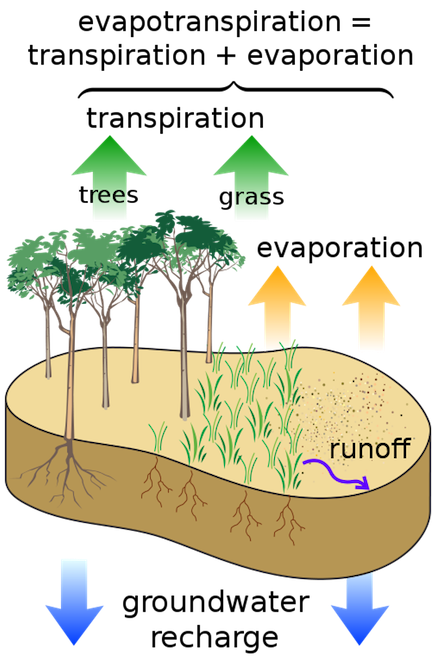
Image Credit: Michael W. Toews

### Main.for

The `Main` driver is where all modules gather. Again, depending on the current stage controlled by `DYN`, a representative function for each module will be called: `PLANT()` for plant module, `SW()` for soil water module, and `WEATHR()` for weather module.

Duration of simulation is determined by a few conditions including hard-coded maximum DOY of 1000 and `endsim` variable turned on after a certain thermal accumulation thershold. Frequency of output recording is also determined by a parameter named `FROP`.

Overall, what a driver is reponsible for often corresponds to what `simulate()` function does in Cropbox.

## Cropbox Implementation of the SimpleCrop model

This simple crop model example is available as a registered Julia package: `SimpleCrop.jl`. [`Cropbox` documentation on "Using an existing model"](https://cropbox.github.io/Cropbox.jl/stable/tutorials/usingamodel/) uses this model as a tutorial example for showing how to use existing model. Take a look at the tutorial and go through the steps.

Now let's build this model with `Cropbox` ourselves here.

In [ ]:
using Cropbox

In [ ]:
using Cropbox.CSV
using Cropbox.DataFrames
using Cropbox.TimeZones
using Dates

In [ ]:
Cropbox.Interact.WebIO.setup(:ijulia)

### Weather module
First we create a `Weather` module. This is similar to what we worked with a few times already previously. Differences are with variables and their names.  First we create a `Weather` module. This is similar to what we worked with a few times already previously. Differences are with variables and their names.  

In [ ]:
@system Weather begin
    calendar(context) ~ ::Calendar
    _w: weather_data ~ provide(index=:DATE, init=calendar.date, parameter)

    DATE ~ drive::date(from=_w)

    SRAD: solar_radiation ~ drive(from=_w, u"MJ/m^2/d")
    #PAR(s): photosynthetically_active_radiation ~ drive(from=_w, u"MJ/m^2/d")
    PAR(SRAD): photosynthetically_active_radiation => 0.5SRAD ~ track(u"MJ/m^2/d")

    TMAX: maximum_temperature ~ drive(from=_w, u"°C")
    TMIN: minimum_temperature ~ drive(from=_w, u"°C")
    TMN(TMAX, TMIN): mean_temperature => begin
        # explicit conversion due to strictness of temperature units handling by Unitful.jl
        0.5(u"K"(TMAX) + u"K"(TMIN))
    end ~ track(u"°C")

    RAIN: rainfall ~ drive(from=_w, u"mm/d")
end

In [ ]:
@system WeatherController(Weather, Controller)

In [ ]:
weather_config = @config (
    :Clock => :step => 1u"d",
    :Calendar => :init => ZonedDateTime(1986, 1, 1, tz"UTC"),
    :Weather => :weather_data => "weather.csv"
)

Let's check the first 7 days of weather data.

In [ ]:
simulate(WeatherController;
    config = weather_config,
    stop = 7u"d",
    index = :DATE,
    target = [:SRAD, :PAR, :TMAX, :TMIN, :TMN, :RAIN],
)

### Plant module
Next is the `Plant` module. We will discuss main points of this module in the context of what we've disussed so far in our class. Let's pay particular attention to processes for biomass accumulation, carbon budget in terms of photosynthesis, respiration, and allocation, plant development, senescence, and scaling to the canopy. Are there any major processes missing or overly simplified? What do you think are strengths and drawbacks of this plant model? 

In [ ]:
@system Plant begin
    DATE ~ hold
    # added for convenience
    DOY(DATE) => Cropbox.Dates.dayofyear(DATE) ~ track::int(u"d")
    # moved from Main
    DOYP: planting_day_of_year => 121 ~ preserve::int(u"d", parameter)

    TMAX: maximum_temperature ~ hold
    TMIN: minimum_tempearture ~ hold
    TMN: mean_temperature ~ hold
    PAR: photosynthetically_active_radiation ~ hold

    SWFAC: soil_water_stress_factor ~ hold

    # distinguish initial values of variables (parameters) from actual variables being updated (i.e. LAI0, N0)
    EMP1: LAI_coeff1 => 0.104 ~ preserve(u"m^2", parameter)
    EMP2: LAI_coeff2 => 0.64 ~ preserve(parameter)
    Fc: canopy_fraction => 0.85 ~ preserve(parameter)
    sla: specific_leaf_area => 0.028 ~ preserve(u"m^2/g", parameter)
    INTOT: duration_of_reproductive_stage => 300.0 ~ preserve(u"K*d", parameter)
    LAI0: initial_leaf_area_index => 0.013 ~ preserve(u"m^2/m^2", parameter)
    Lfmax: maximum_leaf_number => 12.0 ~ preserve(parameter)
    N0: initial_leaf_number => 2.0 ~ preserve(parameter)
    nb: LAI_coeff => 5.3 ~ preserve(parameter)
    # correct units for p1 (g/K, not g)
    p1: leaf_senescence_rate => 0.03 ~ preserve(u"g/K", parameter)
    PD: plant_density => 5.0 ~ preserve(u"m^-2", parameter)
    rm: maximum_leaf_appearance_rate => 0.100 ~ preserve(u"d^-1", parameter)
    Tb: base_temperature => 10.0 ~ preserve(u"°C", parameter)
    To: optimal_temperature => 25.0 ~ preserve(u"°C", parameter) # add this variahle here our lab exercise purpose. 
    W0: initial_plant_dry_matter => 0.3 ~ preserve(u"g/m^2", parameter)
    Wc0: initial_canopy_dry_matter => 0.045 ~ preserve(u"g/m^2", parameter)
    Wr0: initial_root_dry_matter => 0.255 ~ preserve(u"g/m^2", parameter)

    # handle empirical equation for temperature (nounit)
    PT(nounit(TMIN), nounit(TMAX)): photosynthesis_reduction_factor_for_temp => begin
        1.0 - 0.0025 * ((0.25TMIN + 0.75TMAX) - 26.0)^2
    end ~ track

    # introduce RUE parameter with proper units
    RUE: radiation_use_efficiency => 2.1 ~ preserve(u"g/MJ", parameter)
    Pg(PT, SWFAC, RUE, PAR, PD, Y1, LAI): potential_growth_rate => begin
        PT * SWFAC * RUE * PAR/PD * (1 - ℯ^(-Y1 * LAI))
    end ~ track(u"g/d")

    ROWSPC: row_spacing => 60.0 ~ preserve(u"cm", parameter)
    Y1(ROWSPC, PD): canopy_light_extinction_coeff => begin
        # no need to convert units for ROWSPC
        1.5 - 0.768 * (ROWSPC^2 * PD)^0.1
    end ~ preserve

    # introduce flags for organizing rate calculations depending on development phases
    P(DOY, DOYP): planted => (DOY >= DOYP) ~ flag
    VP(P, N, Lfmax): vegetative_phase => (P && N < Lfmax) ~ flag
    RP(N, Lfmax): reproductive_phase => (N >= Lfmax) ~ flag
    #TODO: development phase code no longer needed
    FL(VP, RP): development_phase_code => (VP ? 1 : RP ? 2 : 0) ~ track

    dN(rm, PT): leaf_number_increase => rm * PT ~ track(u"d^-1", when=VP)
    N(dN): leaf_number ~ accumulate(init=N0, when=VP)

    di(TMN, Tb, To): daily_accumulated_temperature => begin
        Tb <= TMN <= To ? TMN - Tb : 0
        # is this logic for leaf area reduction reasonable?
    end ~ track(u"K", when=RP)
    INT(di): accumulated_temperature_during_reproductive_stage ~ accumulate(u"K*d", when=RP)

    _a(EMP2, N, nb) => exp(EMP2 * (N - nb)) ~ track
    dLAI1(SWFAC, PD, EMP1, PT, _a, dN) => begin
        SWFAC * PD * EMP1 * PT * (a/(1+a)) * dN
    end ~ track(u"m^2/m^2/d", when=VP)
    dLAI2(PD, di, p1, sla) => begin
        -PD * di * p1 * sla
    end ~ track(u"m^2/m^2/d", when=RP)
    dLAI(dLAI1, dLAI2): leaf_area_index_increase => dLAI1 + dLAI2 ~ track(u"m^2/m^2/d")
    LAI(dLAI): leaf_area_index ~ accumulate(u"m^2/m^2", init=LAI0)
#    LAI(dLAI): leaf_area_index ~ accumulate(u"m^2/m^2", init=LAI0, min = 0.0u"m^2/m^2")

    E: CH2O_conversion_efficiency => 1.0 ~ preserve(u"g/g", parameter)
    dW(E, Pg, PD) => E * Pg * PD ~ track(u"g/m^2/d")
    W(dW): plant_dry_matter ~ accumulate(u"g/m^2", init=W0, when=P)
    Wc(Fc, dW): canopy_dry_matter => Fc * dW ~ accumulate(u"g/m^2", init=Wc0, when=VP)
    Wr(Fc, dW): root_dry_matter => (1-Fc) * dW ~ accumulate(u"g/m^2", init=Wr0, when=VP)
    Wf(dW): fruit_dry_matter ~ accumulate(u"g/m^2", when=RP)

    endsim(INT, INTOT): end_of_simulation => (INT > INTOT) ~ flag
end

### Soil Water
An important and useful aspect of this model is the `SoilWater` module especially since we haven't had a chance to go through this part in depth in the class. Reviewing this module will help us understand key aspects of soil water balancing. This approach is called a `bucket` model; 1-dimensional and single-layer bucket in this example. There are 1D multi-layer models, 2D models, and 3D models. For evapotranspiration estimation this model uses a modified [Priestley-Taylor method](https://www.hec.usace.army.mil/confluence/hmsdocs/hmstrm/evaporation-and-transpiration/priestley-taylor-method).

Note that this version shown in the next cell differs from `SimpleCrop.jl` package with respect to how `IRR` is handled. Here, loading `IRR` from `irrigation.csv` is not implemented. It shouldn't be a problem here as the original dataset had zero irrigation for the entire term of simulation. But you have an option to turn it back on and add irrigation to the file as needed. Later in the lab, we will do an exercise for deficit irrigation where irrigation will be triggered when the soil moisture goes below a threshold. This version differs from `SimpleCrop.jl` package with respect to how `IRR` is handled. Here, loading `IRR` from `irrigation.csv` is not implemented. It shouldn't be a problem here as the original dataset had zero irrigation for the entire term of simulation. But you have an option to turn it back on and add irrigation to the file as needed. Later in the lab, we will do an exercise for deficit irrigation where irrigation will be triggered when the soil moisture goes below a threshold. 

In [ ]:
@system SoilWater begin
    # make sure we have a correct time interval when doing accumulation (i.e. we may use a non-daily time step)
    Δt(context.clock.step): timestep ~ preserve(u"hr")

    SRAD: solar_radiation ~ hold
    TMAX: maximum_temperature ~ hold
    TMIN: minimum_temperature ~ hold
    RAIN: rainfall ~ hold
    LAI: leaf_area_index ~ hold

    IRR: irrigation => 0.0 ~ track(u"mm/d")
    # disable loading 'IRR' from 'irrigation.csv' for later exercises
    # calendar ~ hold
    # _i: irrigation_data ~ provide(index=:DATE, init=calendar.date, parameter)
    # IRR ~ drive(from=_i, u"mm/d")

    CN: runoff_curve_number => 55 ~ preserve(parameter)
    DP: soil_profile_depth => 145 ~ preserve(u"cm", parameter)
    DRNp: daily_drainage => 0.1 ~ preserve(u"cm^3/cm^3/d", parameter)
    WPp: soil_water_portion_at_wilting_point => 0.06 ~ preserve(u"cm^3/cm^3", parameter)
    FCp: soil_water_portion_at_field_capacity => 0.17 ~ preserve(u"cm^3/cm^3", parameter)
    STp: soil_water_portion_at_saturation => 0.28 ~ preserve(u"cm^3/cm^3", parameter)
    SWC0: initial_soil_water_content => 246.5 ~ preserve(u"mm", parameter)

    # no need for manual conversion from cm to mm (DP*10)
    WP(DP, WPp): soil_water_content_at_wilting_point => DP * WPp ~ preserve(u"mm")
    FC(DP, FCp): soil_water_content_at_field_capacity => DP * FCp ~ preserve(u"mm")
    ST(DP, STp): soil_water_content_at_saturation => DP * STp ~ preserve(u"mm")

    # no need for manual conversion from inch to mm (25.4 mm/inch)
    S(CN): potential_maximum_soil_moisture_retention_after_runoff => begin
        1000/CN - 10
    end ~ preserve(u"inch/d")

    POTINF(RAIN, IRR): potential_infiltration => RAIN + IRR ~ track(u"mm/d")
    ROF(POTINF, S, dROF_extra): runoff => begin
        if POTINF > 0.2S
            (POTINF - 0.2S)^2 / (POTINF + 0.8S)
        else
            0u"mm/d"
        end + dROF_extra
    end ~ track(u"mm/d")
    INF(POTINF, ROF): infiltration => POTINF - ROF ~ track(u"mm/d")

    THE(WP, FC): soil_water_content_threshold => WP + 0.75(FC - WP) ~ preserve(u"mm")

    TRAIN(RAIN): cumulative_rainfall ~ accumulate(u"mm")
    TIRR(IRR): cumulative_irrigation ~ accumulate(u"mm")
    TESa(ESa): cumulative_soil_evaporation ~ accumulate(u"mm")
    TEPa(EPa): cumulative_plant_transpiration ~ accumulate(u"mm")
    TROF(ROF): cumulative_runoff ~ accumulate(u"mm")
    TDRN(DRN): cumulative_vertical_drainage ~ accumulate(u"mm")
    TINF(INF): cumulative_infiltration ~ accumulate(u"mm")

    DRN(SWC, FC, DRNp): vertical_drainage => (SWC - FC) * DRNp ~ track(u"mm/d", min=0)

    # make soil/crop albedo parameters
    αs: soil_albedo => 0.1 ~ preserve(parameter)
    αc: crop_albedo => 0.2 ~ preserve(parameter)
    ALB(LAI, αs, αc): surface_albedo => αs * ℯ^(-0.7LAI) + αc * (1 - ℯ^(-0.7LAI)) ~ track

    Tmed(TMAX, TMIN) => 0.6u"K"(TMAX) + 0.4u"K"(TMIN) ~ track(u"°C")

    # match units of Priestly-Taylor equations
    # http://www.clw.csiro.au/publications/technical98/tr34-98.pdf
    # handle temperature units correctly (°C vs. K)
    EEQ(SRAD, ALB, Tmed): equilibrium_evaporation => begin
        SRAD * (4.88e-3 - 4.37e-3ALB)u"mm^3/J/K" * (Tmed - 0u"°C" + 29u"K")
    end ~ track(u"mm/d")

    # handle empirical equation for temperature (nounit)
    f(nounit(TMAX)) => begin
        if TMAX < 5
            0.01ℯ^(0.18(TMAX + 20))
        elseif TMAX > 35
            1.1 + 0.05(TMAX - 35)
        else
            1.1
        end
    end ~ track
    ETp(f, EEQ): potential_evapotranspiration => f * EEQ ~ track(u"mm/d")
    ESp(ETp, LAI): potential_soil_evaporation => ETp * ℯ^(-0.7LAI) ~ track(u"mm/d")
    EPp(ETp, LAI): potential_plant_transpiration => ETp * (1 - ℯ^(-0.7LAI)) ~ track(u"mm/d")

    _a(SWC, WP, FC) => (SWC - WP) / (FC - WP) ~ track(min=0, max=1)
    ESa(ESp, _a): soil_evaporation => ESp * a ~ track(u"mm/d")
    EPa(EPp, SWFAC): plant_transpiration => EPp * SWFAC ~ track(u"mm/d")

    dSWC(INF, ESa, EPa, DRN, dROF_extra, dSWC_ADJ)=> begin
        INF - ESa - EPa - DRN - dROF_extra + dSWC_ADJ
    end ~ track(u"mm/d")

    # these seemingly complicated extra/adj variables are due to incomplete separation of rate variable calculation and integration logic in the original model
    # handle ROF update w.r.t SWC overflow
    dROF_extra(SWC, ST, Δt) => (SWC - ST) / Δt ~ track(u"mm/d", min=0)
    # handle SWC_ADJ w.r.t SWC underflow
    dSWC_ADJ(SWC, Δt) => -SWC / Δt ~ track(u"mm/d", min=0)
    SWC_ADJ(dSWC_ADJ) ~ accumulate(u"mm")

    SWC(dSWC): soil_water_content ~ accumulate(u"mm", init=SWC0)
    ΔSWC(SWC0, SWC): storage_change => SWC0 - SWC ~ track(u"mm")

    Fi(TRAIN, TIRR) => TRAIN + TIRR ~ track(u"mm")
    Fo(TESa, TEPa, TROF, TDRN) => TESa + TEPa + TROF + TDRN ~ track(u"mm")
    WATBAL(ΔSWC, Fi, Fo) => ΔSWC + Fi - Fo ~ track(u"mm")

    CHECK(TRAIN, TIRR, TROF) => TRAIN + TIRR - TROF ~ track(u"mm")

    # if-else logic replaced by min=0, max=1
    SWFAC1(SWC, WP, THE): drought_stress_factor => (SWC - WP) / (THE - WP) ~ track(min=0, max=1)

    # no need for manual conversion from cm to mm (DP*10)
    WTABLE(SWC, FC, ST, DP): water_table_thickness => (SWC - FC) / (ST - FC) * DP ~ track(u"mm", min=0)
    DWT(DP, WTABLE): water_table_depth => DP - WTABLE ~ track(u"mm")

    STRESS_DEPTH: water_table_depth_threshold => 250 ~ preserve(u"mm", parameter)
    # if-else logic replaced by max=1
    SWFAC2(DWT, STRESS_DEPTH): excess_stress_factor => DWT / STRESS_DEPTH ~ track(min=0, max=1)

    SWFAC(SWFAC1, SWFAC2): soil_water_stress_factor => min(SWFAC1, SWFAC2) ~ track
end

### Main

By the way, we can't name our model `Main` since the name is reserved for Julia. Remember all variables we declare in the default Julia session are bound to `Main` scope.

In [ ]:
@system Model(Plant, SoilWater, Weather, Controller)

We have two years (1986, 1987) of weather data for testing simulation. The model assumes daily time step.

In [ ]:
config = @config (
    :Clock => :step => 1u"d",
    :Calendar => :init => ZonedDateTime(1987, 1, 1, tz"UTC"),
    :Weather => :weather_data => "weather.csv",
#    :SoilWater => :irrigation_data => "irrigation.csv",
    
)

Simulation `stop` condition is determined by `endsim` variable defined in the plant module.

In [ ]:
stop = :endsim

If we want to replicate the behavior of original model printing output for every 3 days, we can set up `snap` callback for `simulate()`.

In [ ]:
# frequency of printout (days)
FROP = 3u"d"

In [ ]:
snap = s -> iszero(s.DOY' % FROP)

Let's stick to the default `snap` behavior that collects simulation output for every time step here.

In [ ]:
snap = nothing

In [ ]:
Cropbox.hierarchy(Model);

In [ ]:
v1 = instance(Model, config=config);

In [ ]:
v1.weather_data[][1:7,:]

In [ ]:
parameters(v1, recursive = true);

## Ex 1. Run simulation and examine results

In [ ]:
r = simulate(Model; config, stop = :endsim);

### Leaf Development

In [ ]:
plot(r, :DOY, :N, kind=:line, ylim=(0,15))

### Leaf Area Expansion

In [ ]:
visualize(Model, :DOY, :LAI; config, stop, snap,
    group = :Plant => :LAI_coeff  => 0:3:9,
#    group = :0 => :LAI_coeff2 => 1.0:-0.2:0.0,
    kind=:line,
);

In [ ]:
visualize(Model, :DOY, :LAI; config, stop, snap,
    group = :0 => :Lfmax => 20:-1:10,
    kind=:line,
)

### Carbon Allocation

In [ ]:
plot(r, :DOY, [:W, :Wc, :Wr, :Wf];
    title = "Dry Matter",
    names = ["Total", "Canopy", "Root", "Fruit"],
    kind = :line,
)

### Phenology

In [ ]:
plot(r, :DOY, [:VP, :RP];
    names = ["Vegetative", "Reproductive"],
    kind = :line,
)

In [ ]:
plot(r, :DATE, :FL, kind=:line)

### Soil Water Content

In [ ]:
plot(r, :DOY, :SWC, kind=:line)

### Water Stress Factor

In [ ]:
plot(r, :DOY, :SWFAC, kind=:line)

## Ex 2. Perform sensitivity analyses of key parameters on state variables of interest

### Leaf Development and Area Expansion

Although quite a number of parameters are in control of leaf development and area expansion, they are mostly empricial without apparent biological or physiological meanings. We list them here and evaluate how leaf deavelopment and leaf area (i.e., LAI) respond to them. 

Leaf development in this model is mainly controlled by three related parameters: initial leaf number (`N0`), maximum leaf number (`Lfmax`), and maximum leaf appearance rate (`rm`). Actual leaf appearance rate (`dN`) is adjusted by temperature effect (`PT`), but thermal time unit is not directly involved in this process.

Reduction of LAI on the reproductive stage is mainly controlled by leaf senescene rate (`p1`) and thermal unit (`di`). A jaggedness of decreasing LAI lends to `di` being discrete.

In [ ]:
manipulate(Model, :DATE, [:N, :LAI]; config, stop, snap,
    parameters = (
        :Plant => (;
            N0 = 0:5,      # initial_leaf_number
            Lfmax = 10:20, # maximum_leaf_number
            rm = 0:0.01:0.4, # maximum_leaf_appearance_rate            
            nb = 0.1:0.1:10,       # LAI_coeff
            EMP1 = 0.01:0.01:0.2,  # LAI_coeff1
            EMP2 = 0.1:0.1:1.2,      # LAI_coeff2
#            sla = 0.01:0.001:0.05, # specific_leaf_area
            p1 = 0.001:0.001:0.2,  # leaf_senescence_rate
            Tb = 0:20,       # base_temperature
            To = 20:30,            
            INTOT = 200:400, # duration_of_reproductive_stage
            
        ),  
    ),
    kind = :line,
    xlim = (Date(1987,4,1), Date(1987, 10, 31)),
    ylim = (0, 20),
)

### Thermal Accumulation and Phenophases

In this model, leaf development rate is adjusted by `PT` parameter which is a function of `TMAX` and `TMIN` temperatures during the vegetatpve phase (`VP`). Once all leaves have developed (i.e., expanded), it transitions to the reproductive phase and thermal accumulation is used for deciding the duration of the reproductive phase (`RP`). The total thermal units (`DI`) starts accumulating with the onset of reproductive stage and stops when it reaches a threshold (`INTOT`).

In [ ]:
visualize(Model, :TMN, :PT; config, stop, snap,
    kind = :line,
)

In [ ]:
manipulate(Model, :DATE, :INT; config, stop, snap,
    parameters = (
        :Plant => (;
            rm = 0:0.01:0.4, # maximum_leaf_appearance_rate                        
            Tb = 5:15,       # base_temperature
            To = 20:30,
            INTOT = 200:400, # duration_of_reproductive_stage
        ),  
    ),
    kind = :line,
    xlim = (Date(1987,5,1), Date(1987, 10, 31)),
    ylim = (0, 400),
)

### Carbon Assimilation

With a simple RUE approach, there are not many parameters other than `RUE` that we can control for photosynthesis process. For an area-based carbon assimilation, plant density (`PD`) and row spacing (`ROWSPC`) can scale up and down the total amount of production as well.

In [ ]:
manipulate(Model, :DOY, [:W, :Wc, :Wr, :Wf]; config, stop, snap,
    parameters = (
        :Plant => (;
            RUE = 0:0.1:5,   # radiation_use_efficiency
            PD = 0.1:0.1:10, # plant_density
            ROWSPC = 1:100,  # row_spacing
        ),  
    ),
    kind = :line,
    xlim = (0, 365),
    ylim = (0, 2000),
)

### Carbon Allocation

Initial dry matter parameters (`W0`, `Wc0`, `Wr0`) doesn't have much sensitivity since dry matter growth rate (`dW`) soley relies on the current photosynthesis rate (`Pg`), not on an existing biomass. Canopy fraction (`Fc`) determines the ratio between canopy and root. Phenology-related parameters such as maximum leaf number (`Lfmax`) also plays an important role since they decide the timing of reproductive phase.

In [ ]:
manipulate(Model, :DOY, [:W, :Wc, :Wr, :Wf]; config, stop, snap,
    parameters = (
        :Plant => (;
            W0 = 0.1:0.1:1,      # initial_plant_dry_matter
            Wc0 = 0.01:0.01:0.3, # initial_canopy_dry_matter
            Wr0 = 0.01:0.01:0.3, # initial_root_dry_matter
            Fc = 0:0.01:1,       # canopy_fraction
            Lfmax = 5:20,        # maximum_leaf_number
        ),  
    ),
    kind = :line,
    xlim = (0, 365),
    ylim = (0, 1500),
)

## Ex 3. Create a new set of parameters for maize crop
Let's create a parameter set that is likely to mimic the growth and development of maize plants. To begin, we reset leaf development parameters. For temperature thresholds we use $T_b$ = 10.0 °C and $T_o$ = 30.0 °C as before. It takes about 2.5 days at optimal temperature to produce leaf ligules (sign of full leaf expasion in grasses) ([Kim et al.,2012](https://doi.org/doi:10.2134/agronj2011.0321)). This translates to `rm = 0.3` at 25 °C in SimpleCrop model. A mid maturity corn hybrid will have about a total of 18 leaves to develop (`Lfmax = 18`). We used the maturity rating of 1500 K previously. Assuming about 60% of the maturity is for reproductive stage,  we give 900 K for the thermal duration of reproductivity stage (`INTOT`). The specific leaf area (SLA) of maize leaves are around 200 $\mathrm{cm^2/g}$ ([Kim et al., 2007](https://doi.org/10.1016/j.envexpbot.2007.06.005)). Previsouly we saw that maize as C4 crop has a theorical RUE value about 1.7 g/MJ for solar radiation (`SRAD`) ([Sinclair and Horie T, 1989](https://doi.org/10.2135/cropsci1989.0011183X002900010023x)). Aassuming `PAR` is a half of `SRAD`, we give 3.4 g/MJ for maize crop with planting density (`PD`) of 8 $\mathrm{plants/m^2}$ and row spacing of 75cm. `P1` is a parameter that determins the rate of leaf tissue senescence in g/K when temperatures are within the range of $T_b$ and $T_o$; a value of 0.05 g/K would mean that it would take one day to lose 1 g of leaf tissue. This values is then multiplied by `SLA` for conversion to leaf area reduction. Other parameters lack clearn biological meaning with unspecific units so we are not going to touch them. 

In [ ]:
c2 = @config (
    :Plant => (;
            N0 = 0,      # initial_leaf_number
            Lfmax = 18,  # maximum_leaf_number
            rm = 0.3,    # maximum_leaf_appearance_rate            
            nb = 5.3,    # LAI_coeff
            sla = 0.02,  # specific_leaf_area
            p1 = 0.05,    # leaf_senescence_rate
            Tb = 10,     # base_temperature
            To = 30,     # optimal_temperature       
            INTOT = 900, # duration_of_reproductive_stage
            RUE = 3.4,   # radiation_use_efficiency
            PD =  8,   # plant_density
            ROWSPC = 75,  # row_spacing
        ),
)

In [ ]:
v2 = instance(Model, config = (config, c2)).weather_data[];

Examine the model behavior for biomass accumulation. Does biomass decrease at the end? How so?

In [ ]:
visualize(Model, :DATE, [:W, :Wc, :Wr, :Wf]; config = (config, c2), stop, snap,
    kind = :line,
    xlim = (Date(1987,4,1), Date(1987, 10, 31)),
    ylim = (0, 1500),
)

Inspect the model behavior for leaf development and leaf area index. Does this explain the pattern of biomass accumulation? How? Can we improve upon this behavior?

In [ ]:
visualize(Model, :DATE, [:N, :LAI]; config = (config, c2), stop, snap,
    kind = :line,
    xlim = (Date(1987,4,1), Date(1987, 10, 31)),
    ylim = (0, 20),
)

## Ex 4. Simulate environmental and management effects

### Idealized climate treatment: Effect of rising temperatures
Let's say we're interested in the effects of rising temperatures on crop yield. A simple way to do this is to apply uniform changes to current temperatures. Without fiddling with temperature data stored in the input file, we can extend the model to accept temperature offset parameters (`ΔTMAX`, `ΔTMIN`) to achieve this.

In [ ]:
@system ModelT(Model, Controller) begin
    ΔTMAX: maximum_temperature_offset => 0 ~ preserve(u"K", parameter)
    ΔTMIN: minimum_temperature_offset => 0 ~ preserve(u"K", parameter)

    TMAX0: maximum_temperature_original ~ drive(from = weather_data, by = :TMAX, u"°C")
    TMIN0: minimum_temperature_original ~ drive(from = weather_data, by = :TMIN, u"°C")
    
    TMAX(TMAX0, ΔTMAX): maximum_temperature => TMAX0 + ΔTMAX ~ track(u"°C")
    TMIN(TMIN0, ΔTMIN): minimum_temperature => TMIN0 + ΔTMIN ~ track(u"°C")
end

In [ ]:
manipulate(ModelT, :DOY, [:TMAX, :TMIN]; config = (config, c2), stop=364u"d",
    parameters = (
        :ModelT => (;
            ΔTMAX = -10:10,
            ΔTMIN = -10:10,
        ),  
    ),
    kind = :line,
    xlim = (0, 365),
    ylim = (-5, 45),
)

Examine model behavior carefully with different levels of and directional changes in temperatures and determine if the response make sense biologically. 

In [ ]:
manipulate(ModelT, :DATE, [:W, :Wc, :Wr, :Wf]; config = (config, c2), stop=364u"d",
    parameters = (
        :ModelT => (;
            ΔTMAX = -10:10,
            ΔTMIN = -10:10,
        ),  
    ),
    kind = :line,
    xlim = (Date(1987,5,1), Date(1987, 10, 31)),
    ylim = (0, 2000),
);

In [ ]:
manipulate(ModelT, :DATE, [:N, :LAI]; config = (config, c2), stop=364u"d",
    parameters = (
        :ModelT => (;
            ΔTMAX = -10:10,
            ΔTMIN = -10:10,
        ),  
    ),
    kind = :line,
    xlim = (Date(1987,5,1), Date(1987, 10, 31)),
    ylim = (0, 20),
);

### Management optons for improving yield
Although simple and limited, this model provides capabilies for evaluating the effectiveness of differnt management options such as irrigation, planting dates, planting density, and row spacing. Let's examine the irrigation option here. Deficit irrigation is an effective irrigation strategie that could improve yield while improving irrigation efficiency by providing water only when its needed. 

We can simulate a deficit irrigation to trigger irrigation at a given threhold of `SWFAC` and evalute if that increases the biomass and yield. We do something similar what we did earlier for adding temperature offsets. Here when it's deemed dry, we will add a fixed amount of irrigation `ΔIRR` as needed.   

In [ ]:
@system ModelI(Model, Controller) begin
    threshold => 0.7 ~ preserve(parameter)
    dry(SWFAC, threshold) => (SWFAC < threshold) ~ flag
    ΔIRR: irrigation_pulse => 0.0 ~ preserve(u"mm/d", parameter)
    IRR(ΔIRR): irrigation => begin
        ΔIRR 
    end ~ track(when = dry, u"mm/d")
end

In [ ]:
config_i = @config (config,
    :SoilWater => (;
        :threshold => 0.7,
        :ΔIRR => 20u"mm/d",
        ),
)

In [ ]:
manipulate(ModelI, :DATE, [:W, :Wc, :Wr, :Wf]; config=(config_i, c2), stop=364u"d",
    parameters = (
        :ModelI => (;
            threshold = 0.5:0.01:1.0,
            ΔIRR = 0:1:30,
        ),  
    ),
    kind = :line,
    xlim = (Date(1987,5,1), Date(1987, 10, 31)),
    ylim = (0, 3000),
)

### Saving new data sets
If we want, we can create a new weather dataset using a new configuration, run weather simulation, and save it as a dataframe. Let's do an warming scenario of a universal 3 $^\circ$C increase throughout the year and save it as `w_3C`.

In [ ]:
c_3C = @config(config,
    :ModelT => (;
        ΔTMAX = 3.0,
        ΔTMIN = 3.0,        
        ),
    )

In [ ]:
w_3 = simulate(ModelT; config=c_3C, stop, target = [:DATE, :SRAD, :PAR, :TMAX, :TMIN, :RAIN]);

We can then save the dataframe as `csv` file but need to strip the units off from the data first so that we can read the dataset as values. You might have encountered issues when saving data with units and trying to reload data. It is unfortunate that `Unitful` package is unable to parse units in the header properly. But we can work around it. One way is to do the following.

In [ ]:
w_3a = deunitfy(w_3)
rename!(w_3a, "SRAD (MJ d^-1 m^-2)" => "SRAD (MJ/d/m^2)",
    "PAR (MJ d^-1 m^-2)" => "PAR (MJ/d/m^2)",  "RAIN (mm d^-1)" => "RAIN (mm/d)") 
CSV.write("weather_3C.csv", w_3a)

In [ ]:
w_3b = CSV.read("weather_3C.csv", DataFrame) |> unitfy
w_3 == w_3b

## Ex 5. Apply SimpleModel for Seattle
Let's now circle back to our earlier exercises where we tried to evaluate if field maize as feed crop is viable in Seattle climate. We first prepare daily weather data with needed input variables to run `SimpleCrop` model. Raw daily weather data for 2021, 2022, and 2023 downloaded from [AgWeatherNet](https://weather.wsu.edu/)  are available with `AWN` in their names. Let's reformat them to be read by `SimpleCrop` model. We also convert units from imperial to SI (e.g., °F to °C, inch to mm). We then save files without `AWN` in the name.

In [ ]:
using Unitful
let
    for year in 2021:2023 
        df = CSV.read("CUH-"*string(year)*"-AWN.csv", DataFrame; header=3);
        select!(df, :Date => :DATE, "Solar Radiation" => "SRAD (MJ/m^2/d)", "1.5 m Min Air Temp" => "TMIN (°C)", "1.5 m Max Air Temp" => "TMAX (°C)", "Precipiation" => "RAIN (mm/d)") |> unitfy
        df[!, 2] = (df[!, 2])
        df[!, 3] = ustrip(u"°C".(df[!, 3]u"°F"))
        df[!, 4] = ustrip(u"°C".(df[!, 4]u"°F"))
        df[!, 5] = ustrip(u"mm/d".(df[!, 5]u"inch/d")) 
        CSV.write("CUH-"*string(year)*".csv", df)
    end
end

We start with weather data for 2021. This was the year Seattle experienced a heat dome in early summer. In 2022, the spring weather was cooler than usual. 

In [ ]:
cCUH = @config (
    :Clock => :step => 1u"d",
    :Calendar => :init => ZonedDateTime(2021, 1, 1, tz"America/Los_Angeles"),
    :Weather => :weather_data => "CUH-2021.csv",
)

In [ ]:
v3 = instance(Model, config=cCUH).weather_data[];

In [ ]:
plot(v3, :DATE, [:TMAX, :TMIN]; kind = :line)

In [ ]:
c = @config(cCUH, c2)

In [ ]:
stop = 364u"d"

In [ ]:
xlim = (Date(2021, 5, 1), Date(2021,10,31))

In [ ]:
visualize(Model, :DATE, [:N, :LAI]; config = c, stop, snap,
    kind = :line,
    xlim,
    ylim = (0, 20),
)

In [ ]:
r3 = simulate(Model; config=(cCUH, c2), stop, snap);

### Leaf Area Expansion

In [ ]:
plot(r3, :DATE, :LAI; xlim, kind=:line)

### Carbon Allocation

In [ ]:
plot(r3, :DATE, [:W, :Wc, :Wr, :Wf];
    title = "Dry Matter",
    names = ["Total", "Canopy", "Root", "Fruit"],
    kind = :line,
    xlim,
)

### Phenology

In [ ]:
plot(r3, :DATE, [:VP, :RP];
    names = ["Vegetative", "Reproductive"],
    kind = :line,
    xlim,
)

In [ ]:
plot(r3, :DATE, :FL; kind=:line, xlim)

### So corn matures in Seattle?
Yield isn't great but it looks like corn plants are able to get in to the reproductive stage in mid July which is resonable. This is different result than our previous exercise where it appeared there wasn't enough heat units to grow feed corn in Seattle. What's the difference?

### Soil Water Content

In [ ]:
plot(r3, :DATE, :SWC; kind=:line)

### Water Stress Factor

In [ ]:
plot(r3, :DATE, :SWFAC, kind=:line)

### Need irrigation?
It looks like plants are getting water stress from June in Seattle. Let's simulate a deficit irrigation to trigger irrigation at a given threhold of `SWFAC` and evalute if that increases the biomass and yield. We will do something similar what we did earlier for adding temperature offsets. Here when it's deemed dry, we will add a fixed amount of irrigation `ΔIRR` as needed. 

In [ ]:
cCUHi = @config (cCUH,
    :SoilWater => (;
        :threshold => 0.7,
        :ΔIRR => 20u"mm/d",
        ),
)

In [ ]:
r3i = simulate(ModelI; config=(cCUHi, c2), stop, snap);

In [ ]:
plot(r3i, :DATE, :SWC; kind=:line, xlim)

### Water Stress Factor

In [ ]:
plot(r3i, :DOY, :SWFAC, kind=:line)

### Rainfall and Irrigation

In [ ]:
plot(r3i, :DOY, [:RAIN, :IRR], kind=:line)

### Leaf Area Expansion

In [ ]:
plot(r3i, :DATE, :LAI; xlim, kind=:line)

### Carbon Allocation

In [ ]:
plot(r3i, :DATE, [:W, :Wc, :Wr, :Wf];
    title = "Dry Matter",
    names = ["Total", "Canopy", "Root", "Fruit"],
    kind = :line,
    xlim,
)

## Ex 6. Modify SimpleModel for a different crop of your choice to grow in Seattle
Adjust the values of five parameters that you identified as key parameters of the Simplecrop model to create a new set of parameters. Use this parameter set to simulate the growth, development, and yield of a crop of your choice to grow in Seattle weather. Evaluate the model sensitivity and examine if and how you can improve its yield using management options that you can adjust with  the model. 